# Extracting Average Amplitude Modulation 

## Deepanshi Shokeen [MS in Health Data Science, Dartmouth College]

### PI : Dr. Michael Casey - Bregman Lab, Dartmouth College

The following analysis is done by Deepanshi Shokeen under the guidance of Prof. Michael Casey, Director of Dartmouth College Music Department for her **Capstone Project**.

*The code is based on the signal processing analysis of amplitude modulation spectrum done by Prof. Michael Casey  https://github.com/bregmanstudio/MusicAM

The analysis was done to look at the amount of modulation energy in gamma band for pieces from differnt music genres like Ambience, Classic Country, Classical, Non-Western, Heavy Metal, Rock and Roll etc. 

In [1]:
# Importing Libraries

import scipy
from scipy.stats import wilcoxon, ttest_rel, ttest_ind, ttest_1samp, mannwhitneyu, spearmanr, pearsonr
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib
import os
import pickle
import os, fnmatch
from os import listdir
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile

In [2]:
get_ipython().run_line_magic('cd', '/Users/deepanshishokeen/desktop/capstone/work/amplitude-modulation-analysis-module')
from am_analysis import am_analysis as ama
mpl=matplotlib.pyplot

# Controls which version of the amplitude modulation spectrogram
mod_feat = 'power_modulation_spectrogram' 

/Users/deepanshishokeen/Desktop/Capstone/work/amplitude-modulation-analysis-module


In [3]:
# Root mean square : RMS Normalizing the one-minute segment of music that we are analyzing so that a segment 
# has the same RMS value to the other segment that we are comparing it to
rms = lambda x: np.sqrt(np.square(x).mean())

# dB is the power-decibel conversion
dB = lambda y: 10*np.log10(y)

# Objfun to extract the mean mod power from pieces
objfun = lambda x: dB((np.mean(x,0).squeeze())+10**(-12))


In [4]:
# f_range : It defines the range of frequency. Deciding on frequency 500 Hz to 4000 Hz
# modf_range : Selecting the modulation frequency range or the bands by entering lower and upper limits
# Testing hypothesis for Gamma Band i.e 30Hz-60Hz

# Other modulation frequency band can also be tested i.e  delta (1–4 Hz), theta (4–8 Hz), beta (13–30 Hz), 
# low gamma (30–70 Hz), and high gamma (70–150 Hz) bands, 
# where faster rhythms such as gamma activity have been linked to cognitive processing

from statistics import mean
def abs_mod(mod_spec, f_range=np.array([500,4000]), modf_range=np.array([30,60]), c_range=np.array([20,80]), ttl=None, avg=False, ref=None):
    print("Freq Range:", f_range, ", ModFreq Range:", modf_range)
    mn=mod_spec[mod_feat] 
    amx=mod_spec['freq_mod_axis']
    amy=mod_spec['freq_axis']
    midx=np.where((amx>=modf_range[0]) & (amx<modf_range[1]))[0]
    midy=np.where((amy>=f_range[0]) & (amy<f_range[1]))[0]
    if ref is None: 
        rf=mn
    else:
        rf = ref
    w = objfun(mn[midy][:,midx,:])
    print(sum(w))
    print(mean(w))
    p = sum(w), mean(w)
    if ref is not None:
        objfun(rf[midy][:,midx,:])
    return p[0],p[1]

In [5]:
# Function abs_avg_mod is for specifying micro macro windowing parameters.

# Micro Windowing(For frequency)

## N = STFT Length, this represents that the window is 1024 samples long. 
## The window size for the first Fourier transform is of 44100 samples and we are dividing those by1024 to get the spacing of linear frequency
## which gives us about 43 Hz for each second. This means that we are getting one sample in about 50Hz, two samples in 100Hz and so on. 

## We have decided the hop size to be 0.005 and are multiplying it by sampling rate

# Macro Windowing(For Modulation frequency)
# Collected the modulation spectrum over one-minute window for each 2 seconds for one second spacing

## FL = Frame Length (seconds) 
## FR = Frame Rate (frames per second) 

def abs_avg_mod(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', t_range=None, FL=2, FR=1, N=1024, hop=0.005):
    fs,x = scipy.io.wavfile.read(fname, mmap=True)
    print(fs,len(x))
    if not len(x):
        print( "File not read:", fname )
        return
    else:
        print ( "Loaded",fname,"len:",len(x) )
    win_size = int(fs*FL)
    win_shift = int(fs/FR)
    if t_range is None:
        t_range = [60,120]
    sig = x[t_range[0]*fs:t_range[1]*fs,0].reshape(-1,1) # LEFT CHANNEL
    sig = sig / rms(sig) # normalize RMS 
    x_segmented, _, _ = ama.epoching(sig, win_size, win_size-win_shift)
    n_segments  = x_segmented.shape[2]
    mod_spec = []
    for i_segment in range(0,n_segments):
        x_tmp = x_segmented[:,:,i_segment]
        ms=ama.strfft_modulation_spectrogram(x_tmp, fs, N, int(fs*hop))
        mod_spec.append(ms)
    data = []
    for m in mod_spec:    
        data.append(m[mod_feat][:,:,0])
    data = np.array(data)    
    nmm = data.mean(0) # average modulation spectrum
    mod_spec[0][mod_feat][:,:,0]=nmm
    return mod_spec[0]

In [6]:
# Default is K448
# T=[0,1,2], represents that we are doing analysis for first three minute segments 
def get_mod_spec(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', T=[0,1,2], ttl='Mozart K.448', avg=False, hist=False, plotting=True, ref=None):
    res = []
    abs_sum = []
    abs_mean = []
    for t in T:
        res.append(abs_avg_mod(fname=fname, t_range=[t*60,(t+1)*60]))
        if plotting:
            abs=abs_mod(res[t], ttl='%s, T=%02d:00-%02d:00'%(ttl,t,t+1), avg=avg, ref=ref)
            abs_sum.append(abs[0])
            abs_mean.append(abs[1])
    return res, abs_sum, abs_mean


In [7]:
matplotlib.rcParams['figure.figsize']=(12,6)
def make_reference_mod_spec(x):
    y=np.array([r[mod_feat] for r in x]).mean(0)
    return y

In [8]:
res_448, sum_448, mean_448 = get_mod_spec('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', avg=True)


44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1715.320420124006
-29.07322745972892
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1675.7540653715341
-28.402611277483636
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1606.448249583406
-27.227936433617046


In [9]:
ref_448 = make_reference_mod_spec(res_448)
res_448, sum_448, mean_448 = get_mod_spec(avg=True, ref=ref_448)

44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1715.320420124006
-29.07322745972892
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1675.7540653715341
-28.402611277483636
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1606.448249583406
-27.227936433617046


ref_448 = make_reference_mod_spec(res_448)
res_448, w_448 = get_mod_spec(avg=True, ref=ref_448)

In [12]:
res_545, sum_545, mean_545 = get_mod_spec('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav', ttl='Mozart K545', ref=ref_448, avg=True)


44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2096.9643922818955
-35.54176936071009
44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1954.363400737744
-33.12480340233465
44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1816.9494500115616
-30.79575339002646


In [13]:
#my_list=[]
#mypath= '/Volumes/LaCie/Preferred Music Corpus/Country'
#for root, dirnames, filenames in os.walk(mypath):
 #   for filename in filenames:
  #      if filename.endswith('.wav'):
   #             files.append(os.path.join(filename))

#z = []
#slash='/'
#for j in files:
 #   ttl=j.replace('.wav','')
  #  res,abs_sum,abs_mean=get_mod_spec(mypath+slash+j,ttl=ttl, ref=ref_448)
   # ttl=[ttl,ttl,ttl]
    #for i in range(3):
     #   z=ttl[i],abs_sum[i],abs_mean[i]
      #  my_list.append(z)

## For Non-Western genre

In [14]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Non-western'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
print(len([f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]))


z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    
    # We are excluding music pieces which are less than 2 minutes 20 seconds 
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)

20
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1782.3797724072588
-30.20982665097049
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1731.126251650637
-29.34112290933284
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1867.5484196330326
-31.653363044627678
44100 6769056
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/07 Various - Punleu Prey Viel (Cambodia).wav len: 6769056
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2267.990294062196
-38.44051345868128
44100 6769056
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/07 Various - Punleu Prey Viel (Cambodia).wav len: 676

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2395.4143161363286
-40.60024264637846
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2187.4658829018717
-37.07569293054019
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2717.1201402106008
-46.05288373238307
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2161.607911994721
-36.63742223719867
44100 8869980
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/19 Various - Anasazi Visions (U.S.A).wav len: 8869980
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-3093.1403089444793
-52.42610693126235
44100 8869980
Loaded /Volumes/LaCie/P

In [15]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/non_western.xlsx')  
df_nw = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/non_western.xlsx')

In [16]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Heavy Metal'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    
    # We are excluding music pieces which are less than 2 minutes 20 seconds 
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1251.7032191067092
-21.21530879841881
44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1067.684955857271
-18.096355184021544
44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-932.9089989369759
-15.812016931135185
44100 7799820
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 System Of A Down - Old School Hollywood.wav len: 7799820


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 7799820
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 System Of A Down - Old School Hollywood.wav len: 7799820
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 7799820
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 System Of A Down - Old School Hollywood.wav len: 7799820
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-472.3709952579199
-8.006288055218981
44100 19361076
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Judas Priest - Starbreaker [Live 9.05.1978 in Cleveland, The United States].wav len: 19361076
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1041.1194912572867
-17.646093072157406
44100 19361076
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Judas Priest - Starbreaker [Live 9.05.1978 in Cleveland, The United States].wav len: 19361076
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 19361076
Loaded /Volumes/LaCie/Preferred Music 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 12668460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/01 Judas Priest - Never Satisfied.wav len: 12668460
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 14076720
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/08 Judas Priest - Love Bites [Live 23.05.1986 in St. Louis, The United States].wav len: 14076720
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-637.5113437027956
-10.805277011911786
44100 14076720
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/08 Judas Priest - Love Bites [Live 23.05.1986 in St. Louis, The United States].wav len: 14076720
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 14076720
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/08 Judas Priest - Love Bites [Live 23.05.1986 in St. Louis, The United States].wav len: 14076720
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
72.31178847321152
1.225623533444263
44100 10940916
Loaded /Vo

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-794.5451764647693
-13.466867397707952
44100 26938044
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Sunn O))) - Cursed Realms (Of The Winterdemons).wav len: 26938044
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 9319800
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 System Of A Down - Violent Pornography.wav len: 9319800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-447.82663165109096
-7.590281892391374
44100 9319800
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 System Of A Down - Violent Pornography.wav len: 9319800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-364.7198760446272
-6.181692814315716
44100 9319800
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 System Of A Down - Violent Pornography.wav len: 9319800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-355.756237760811
-6.029766741708662
44100 16472820
Loaded /Volumes/LaCie/Preferred Music Corpus/Hea

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 8152620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Nickelback - Hollywood.wav len: 8152620
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-382.9391254459608
-6.490493651626453
44100 8152620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Nickelback - Hollywood.wav len: 8152620
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 8152620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Nickelback - Hollywood.wav len: 8152620
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 16099440
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/05 Judas Priest - Painkiller.wav len: 16099440
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 16099440
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/05 Judas Priest - Painkiller.wav len: 16099440
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 16099440
Loaded /Volumes/LaCie/Preferred M

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 12653760
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Devil's Child.wav len: 12653760
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-623.8937615276986
-10.574470534367775
44100 12653760
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Devil's Child.wav len: 12653760
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 12653760
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Devil's Child.wav len: 12653760
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 11299008
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Delivering the Goods.wav len: 11299008
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-454.40091739513315
-7.701710464324291
44100 11299008
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Delivering the Goods.wav len: 11299008
Freq Range: [ 500 4000] , Mod

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-882.7578987397555
-14.961998283724673
44100 8025024
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Judas Priest - Take On the World.wav len: 8025024
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-518.3831557000221
-8.786155181356309
44100 8025024
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Judas Priest - Take On the World.wav len: 8025024
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-503.10281676834074
-8.52716638590408
44100 8025024
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Judas Priest - Take On the World.wav len: 8025024
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-393.056301622747
-6.661971213944866
44100 9748452
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Motörhead - Bomber.wav len: 9748452
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-35.39797824872055
-0.5999657330291618
44100 9748452
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Motörh

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 14424816
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/12 Judas Priest - Bloodstained.wav len: 14424816
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
323.7094553206676
5.486600937638433
44100 10929744
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Judas Priest - Some Heads Are Going to Roll.wav len: 10929744
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 10929744
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Judas Priest - Some Heads Are Going to Roll.wav len: 10929744
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 10929744
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Judas Priest - Some Heads Are Going to Roll.wav len: 10929744
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 9075780
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/09 System Of A Down - Sad Statue.wav len: 9075780
Freq Range: [ 500 4000] , ModFreq 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 15182160
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 Judas Priest - A Touch of Evil.wav len: 15182160
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-51.55684421189153
-0.8738448171507038
44100 15182160
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 Judas Priest - A Touch of Evil.wav len: 15182160
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 15182160
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 Judas Priest - A Touch of Evil.wav len: 15182160
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 7021308
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Motörhead - No Class.wav len: 7021308
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 7021308
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Motörhead - No Class.wav len: 7021308
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 7021308
Loaded /Volumes

In [17]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/heavy_metal.xlsx') 
df_hm = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/heavy_metal.xlsx')

## For Classic Country genre

In [18]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Country/Classic Country'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    
    # We are excluding music pieces which are less than 2 minutes 20 seconds 
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1755.128260674893
-29.747936621608353
44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1829.1828826819353
-31.00309970647349
44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1918.2608067116917
-32.51289502901172
44100 8601264
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Ray Charles - You Don't Know Me.wav len: 8601264
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1788.6426353404013
-30.315976870176286
44100 8601264
Loa

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
163.55129320323252
2.7720558170039404
44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1623.7426686551578
-27.521062180595898
44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1260.2365159723834
-21.359940948684464
44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1540.9527992046105
-26.117844054315444
44100 7472304
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Jimmie Davis - You Are My Sunshine.wav len: 7472304
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1595.8922752759609
-27.04902161484679
44100 7472304
Loaded /Volumes/LaCie/

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1683.8718684560927
-28.540201160272748
44100 7688100
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/01 Jerry Lee Lewis - You Win Again.wav len: 7688100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1731.8610942234177
-29.353577868193515
44100 7688100
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/01 Jerry Lee Lewis - You Win Again.wav len: 7688100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1558.4577396828852
-26.41453796072686
44100 7688100
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/01 Jerry Lee Lewis - You Win Again.wav len: 7688100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1538.5354115655261
-26.07687138246654
44100 6809040
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Eddy Arnold - I Really Don't Want to Know.wav len: 6809040
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1375.6877334465116
-23.31674124485613
44100 68

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1538.3528551636862
-26.07377720616417
44100 7879788
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/13 Ray Charles - You Are My Sunshine.wav len: 7879788
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1315.6144693602853
-22.298550328140426
44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1868.8034373571077
-31.674634531476404
44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2086.37163624525
-35.36223112280085
44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2206.030850547517
-37.390353399110445
44100 687

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1582.9175265575138
-26.829110619618866
44100 7078344
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Tammy Wynette - Stand by Your Man.wav len: 7078344
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1466.33303706551
-24.853102323144245
44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's Sweetheart.wav len: 8370180
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1472.917328365545
-24.96470048077195
44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's Sweetheart.wav len: 8370180
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1598.6176365005779
-27.095214177975897
44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's Sw

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1777.0545182429428
-30.11956810581259
44100 7774536
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/08 Riley Puckett - Ragged But Right.wav len: 7774536
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1723.6713055407818
-29.214767890521724
44100 7774536
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/08 Riley Puckett - Ragged But Right.wav len: 7774536
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1940.5099021931087
-32.88999834225608
44100 8738856
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tom T. Hall - Homecoming.wav len: 8738856
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1337.9919310215876
-22.67782933934894
44100 8738856
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tom T. Hall - Homecoming.wav len: 8738856
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1433.9251388219411
-24.30381591223629
44100 8738856
Loaded /Volumes/L

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1633.4879917985754
-27.6862371491284
44100 8647128
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/14 Ray Charles - Here We Go Again.wav len: 8647128
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1916.6690846884073
-32.485916689634024
44100 8647128
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/14 Ray Charles - Here We Go Again.wav len: 8647128
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1671.6748389598185
-28.33347184677659
44100 7968576
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/07 The Maddox Brothers & Rose - Philadelphia Lawyer.wav len: 7968576
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1442.1986154599965
-24.444044329830447
44100 7968576
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/07 The Maddox Brothers & Rose - Philadelphia Lawyer.wav len: 7968576
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1388.795528479468
-23.538

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1766.7068163962292
-29.94418332874965
44100 8506008
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/13 W. Lee O'Daniel and his Light Crust Doughboys with Leon Huff - My Mary.wav len: 8506008
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1568.9599662878277
-26.592541801488604
44100 8506008
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/13 W. Lee O'Daniel and his Light Crust Doughboys with Leon Huff - My Mary.wav len: 8506008
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1954.3971413290608
-33.12537527676374
44100 7214760
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/17 Hank Williams - Lovesick Blues.wav len: 7214760
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1628.4721790517008
-27.601223373757637
44100 7214760
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/17 Hank Williams - Lovesick Blues.wav len: 7214760
Freq Range: [ 500 4000] , ModF

In [19]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classic_country.xlsx') 
df_cc = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classic_country.xlsx')

## For Ambience genre

In [20]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Ambient Music'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    
    # We are excluding music pieces which are less than 2 minutes 20 seconds 
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1885.3989831759245
-31.955914969083473
44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1740.0734252218201
-29.492769919013895
44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1524.2784751432432
-25.83522839225837
44100 21920640
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/04 Brian Eno - Three Variations on the "Canon in D Major" by Johann Pachelbel, III： Brutal Ardour.wav len: 21920640
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2085.7564551788146
-35.35180432506465
44100 21920640
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/04 Brian Eno - Thre

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 13556340
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/10 pimmon - cakewalking.wav len: 13556340
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 13556340
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/10 pimmon - cakewalking.wav len: 13556340
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-915.2122674396721
-15.512072329485967
44100 8848224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/12 Brian Eno—David Byrne - Very, Very Hungry.wav len: 8848224
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2077.0285640104507
-35.20387396627883
44100 8848224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/12 Brian Eno—David Byrne - Very, Very Hungry.wav len: 8848224
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1792.9930804389933
-30.389713227779556
44100 8848224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/12 Brian Eno—David Byrne - Very, Very Hungry.w

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2106.7692400530027
-35.70795322123734
44100 15062208
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 pimmon - feather prophet.wav len: 15062208
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1895.0859204850562
-32.12010034720435
44100 15062208
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 pimmon - feather prophet.wav len: 15062208
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1398.1310711596188
-23.697136799315576
44100 15062208
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 pimmon - feather prophet.wav len: 15062208
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1331.4252063546082
-22.56652892126455
44100 28956060
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/05 Terre Thaemlitz - A City on Springs.wav len: 28956060
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-3296.2188493098606
-55.86811608999762
44100 28956060
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient 

44100 7497588
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/06 pimmon - by 5's [for 27].wav len: 7497588
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2292.34767381158
-38.853350403586106
44100 7497588
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/06 pimmon - by 5's [for 27].wav len: 7497588
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2349.798391732788
-39.827091385301486
44100 7497588
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/06 pimmon - by 5's [for 27].wav len: 7497588
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1803.7849007689488
-30.572625436761843
44100 7796880
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/07 Brian Eno - St. Elmo's Fire.wav len: 7796880
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1841.6293975481608
-31.214057585562042
44100 7796880
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/07 Brian Eno - St. Elmo's Fire.wav len: 7796880
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1531.4732967426596
-25.957174521062022
44100 15362676
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/02 Terre Thaemlitz - Fat Chair.wav len: 15362676
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2553.6976961030637
-43.28301179835702
44100 15362676
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/02 Terre Thaemlitz - Fat Chair.wav len: 15362676
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2419.1205672508236
-41.00204351272581
44100 15362676
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/02 Terre Thaemlitz - Fat Chair.wav len: 15362676
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2429.2530728725656
-41.17378089614517
44100 14029680
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 Brian Eno - Three Variations on the "Canon in D Major" by Johann Pachelbel, II： French Catalogues.wav len: 14029680
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2184.2499030315153
-37.021184797144

44100 33703572
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 Jacob Kirkegaard - Church.wav len: 33703572
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2499.3673467902836
-42.36215842017431
44100 33703572
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 Jacob Kirkegaard - Church.wav len: 33703572
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2077.524974861431
-35.21228770951577
44100 7946232
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 pimmon - sleeping bird's dream.wav len: 7946232
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-825.6113110039969
-13.993412050915197
44100 7946232
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 pimmon - sleeping bird's dream.wav len: 7946232
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-131.5778088947926
-2.2301323541490277
44100 7946232
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 pimmon - sleeping bird's dream.wav len: 7946232
Freq Range: [ 500 4000] , ModFreq R

In [21]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/ambience.xlsx') 
df_amb = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/ambience.xlsx')

## For Rock n' Roll genre

In [22]:
my_list=[]
mypath= "/Volumes/LaCie/Preferred Music Corpus/Rock n' Roll"
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)

    # We are excluding music pieces which are less than 2 minutes 20 seconds 
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1410.1319945817893
-23.90054228104728
44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1126.0435571907549
-19.08548402018228
44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1095.012381674089
-18.559531892781166
44100 10504620
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Joe Cocker & Jennifer Warnes - Up Where We Belong.wav len: 10504620
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2273.901216538119
-38.540698585391844
44100 10504620
Loaded /Volumes/LaCie/Preferred Musi

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1325.6344699276347
-22.4683808462311
44100 6613824
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Terry Stafford - Suspicion.wav len: 6613824
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1279.7180836065002
-21.690137010279667
44100 6613824
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Terry Stafford - Suspicion.wav len: 6613824
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1472.4403184934476
-24.95661556768554
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Tommy James & The Shondells - Mony Mony.wav len: 7646940
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1006.384491973989
-17.05736427074558
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Tommy James & The Shondells - Mony Mony.wav len: 7646940
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-957.278166859844
-16.225053675590576
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corpus/R

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1299.1710204002654
-22.019847803394338
44100 6925464
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Bobby Vee - Take Good Care of My Baby.wav len: 6925464
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-701.2673804928173
-11.885887804963001
44100 6925464
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Bobby Vee - Take Good Care of My Baby.wav len: 6925464
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1410.7044020837786
-23.910244103114888
44100 7958580
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 The Miracles - Love Machine - Pt. 1.wav len: 7958580
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1404.5171896936804
-23.805376096503064
44100 7958580
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 The Miracles - Love Machine - Pt. 1.wav len: 7958580
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1058.2579518359987
-17.936575454847436
44100 7958580
Loaded /Volumes/LaCie/Pref

44100 6387444
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 The Lemon Pipers - Green Tambourine.wav len: 6387444
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1230.8898342557768
-20.862539563657236
44100 6387444
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 The Lemon Pipers - Green Tambourine.wav len: 6387444
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1175.0630169892052
-19.916322321850927
44100 6387444
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 The Lemon Pipers - Green Tambourine.wav len: 6387444
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2222.5639387948895
-37.6705752338117
44100 7160664
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Dion - Runaround Sue.wav len: 7160664
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1212.1244560143318
-20.544482305327655
44100 7160664
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Dion - Runaround Sue.wav len: 7160664
Freq Range: [ 500 4000] , ModFreq Ra

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1725.6087466983854
-29.247605876243814
44100 6582660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Buddy Holly - Peggy Sue.wav len: 6582660
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1615.316798931593
-27.378250829349035
44100 6582660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Buddy Holly - Peggy Sue.wav len: 6582660
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2157.865125694598
-36.57398518126438
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Charlie Brown.wav len: 6326880
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1265.1499305786476
-21.44321916234996
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Charlie Brown.wav len: 6326880
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1263.2167958560485
-21.41045416705167
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Charlie 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1259.6122938304115
-21.34936091237985
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1488.7368652808696
-25.232828225099485
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1318.5527842775987
-22.348352275891497
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1602.0306304562178
-27.153061533156237
44100 7620480
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Crests - Sixteen Candles.wav len: 7620480
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1227.691297802913
-20.8083270814053
44100 7620480
Loaded /Volumes/LaCie/Preferred Music 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1216.2557388844596
-20.61450404888915
44100 7026600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 The Lovin' Spoonful - Summer In The City.wav len: 7026600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1551.0610013433225
-26.289169514293594
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1203.0795122913182
-20.391178174429122
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-984.558359569689
-16.687429823215066
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-947.2084226736933
-16.05438004531684
44100 7427616
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-957.9991647560087
-16.2372739789154
44100 6470940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 The Marvelettes - Please Mr. Postman.wav len: 6470940
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1318.673152811805
-22.350392420539073
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Angels - My Boyfriend's Back.wav len: 6906060
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1094.6230912345163
-18.552933749737566
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Angels - My Boyfriend's Back.wav len: 6906060
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1023.6145164084727
-17.349398583194446
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Angels - My Boyfriend's Back.wav len: 6906060
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1221.621297706271
-20.705445723835094
44100 7150080
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' R

44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1670.6894850928363
-28.316770933776887
44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1189.903057262853
-20.16784842818394
44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1006.8938486508299
-17.065997434759833
44100 7965048
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Shirley Ellis - The Name Game.wav len: 7965048
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1425.3670386010258
-24.15876336611908
44100 7965048
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Shirley Ellis - The Name Game.wav len: 7965048
Freq Range

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1240.850119984487
-21.03135796583877
44100 12306840
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Oliver - Good Morning Starshine.wav len: 12306840
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1293.8281302517562
-21.9292903432501
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1675.4329228419213
-28.39716818376138
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1313.1696953281144
-22.257113480137534
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-924.8162961894112
-15.67485247778663
44100 6332760
Loaded /Volumes/LaCie/Preferr

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-930.6762576983222
-15.774173859293594
44100 7833924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Yvonne Elliman - If I Can't Have You.wav len: 7833924
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-529.7925810397184
-8.979535271859634
44100 7833924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Yvonne Elliman - If I Can't Have You.wav len: 7833924
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1068.30990008243
-18.10694745902424
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various - Edwin Starr - War.wav len: 8937600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1230.3130230505894
-20.852763102552355
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various - Edwin Starr - War.wav len: 8937600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1032.8870078425389
-17.506559454958282
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1014.4702743485122
-17.194411429635803
44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1582.0504201508606
-26.814413900862046
44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1364.8108450618488
-23.13238720443812
44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1857.2768962365278
-31.47926942773777
44100 10112424
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Daryl Hall & John Oates - Kiss on My List.wav len: 10112424
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1270.2911304790418
-21.530358143712576
44100 10112424
Loaded /Volumes/LaCie/Preferred Music Co

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-949.3559009177006
-16.090777981655943
44100 8127924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - Shocking Blue - Venus.wav len: 8127924
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1093.6719634989972
-18.536812940660973
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1231.994331410185
-20.88125985440991
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1043.3222279967267
-17.68342759316486
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-900.0151536161485
-15.254494129087265
44100 9323916
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Bonnie Tyl

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1110.9616795295096
-18.829858975076437
44100 7063644
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 The Tokens - The Lion Sleeps Tonight.wav len: 7063644
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-903.9377009124061
-15.320977981566203
44100 7063644
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 The Tokens - The Lion Sleeps Tonight.wav len: 7063644
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1315.0331522470829
-22.288697495713283
44100 9349200
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various Artists - Rose Royce - Car Wash.wav len: 9349200
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1783.286060103078
-30.225187459374197
44100 9349200
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various Artists - Rose Royce - Car Wash.wav len: 9349200
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1120.9498155088204
-18.999149415403732
44100 9349200
Loaded /Volumes/LaCie

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1205.5722880251137
-20.433428610595154
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1264.9586568490988
-21.439977234730485
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1034.7151898957998
-17.53754559145423
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-820.3796954859247
-13.90474060145635
44100 6225744
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 Chuck Berry - Maybellene.wav len: 6225744
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-971.4419881742961
-16.46511844363214
44100 62257

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1448.4193035509036
-24.549479721201756
44100 7354116
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Bill Haley & The Comets - See You Later, Alligator.wav len: 7354116
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1003.9200281964997
-17.01559369824576
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1016.2674803009384
-17.224872547473527
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-787.5506111552595
-13.348315443309483
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-983.7387252966761
-16.673537716892824
44100 9

44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1147.7515692463744
-19.45341642790465
44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1086.6512832024475
-18.417818359363523
44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1412.6707205772154
-23.943571535207035
44100 8694756
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Climax Blues Band - Couldn't Get It Right.wav len: 8694756
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1375.2133753386688
-23.30870127692659
44100 8694756
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Climax Blues Band - Couldn't Get It Right.wav l

44100 9081660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/05 The Edgar Winter Group - Frankenstein.wav len: 9081660
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-777.0392893047682
-13.17015744584353
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1002.0174727061562
-16.983346995019605
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-894.2217405219433
-15.156300686812603
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1206.3313064600106
-20.446293329830688
44100 9233364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Little River Band - Reminiscing.wav len: 9233364
Freq Range: [ 500 4000] , ModFreq

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 6246324
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Big Bopper - Chantilly Lace.wav len: 6246324
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1276.738839883657
-21.639641353960283
44100 6246324
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Big Bopper - Chantilly Lace.wav len: 6246324
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
nan
nan
44100 14097888
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John - Bennie and the Jets.wav len: 14097888
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1400.081990408847
-23.730203227268593
44100 14097888
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John - Bennie and the Jets.wav len: 14097888
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-999.1496021920476
-16.934739020204194
44100 14097888
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John - Bennie and the Jets.wav len: 14097888
F

44100 10755696
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Steam - Na Na Hey Hey (Kiss Him Goodbye).wav len: 10755696
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1461.523631174698
-24.77158696906268
44100 10755696
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Steam - Na Na Hey Hey (Kiss Him Goodbye).wav len: 10755696
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1600.5940189693451
-27.128712185921113
44100 10556364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Abba - Take A Chance On Me.wav len: 10556364
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1042.0805213356869
-17.66238171755402
44100 10556364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Abba - Take A Chance On Me.wav len: 10556364
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-820.5112425838857
-13.906970213286197
44100 10556364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Abba - Take A Chance On Me.wav len: 10556364
Freq Range: [ 5

44100 6577956
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Joe Jones - You Talk Too Much.wav len: 6577956
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1307.6821688806544
-22.16410455729923
44100 6577956
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Joe Jones - You Talk Too Much.wav len: 6577956
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1003.8328458996878
-17.014116032198096
44100 6577956
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Joe Jones - You Talk Too Much.wav len: 6577956
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1221.6974839742263
-20.706737016512314
44100 13832700
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 Rod Stewart - Maggie May.wav len: 13832700
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1146.2644655569902
-19.428211280626957
44100 13832700
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 Rod Stewart - Maggie May.wav len: 13832700
Freq Range: [ 500 4000] , ModFreq Range: 

In [23]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/rock_n_roll.xlsx') 
df_rnr = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/rock_n_roll.xlsx')

## For Classical genre

In [24]:
roots=[]
files=[]
my_list=[]
mypath= '/Volumes/LaCie/PSYC90 Corpus Study'
for root, dirnames, filenames in os.walk(mypath):
    for filename in filenames:
        if filename.endswith('.wav') and not filename.startswith("._"):
                files.append(os.path.join(filename))
                roots.append(os.path.join(root,filename))

z = []
slash='/'
for i,j in zip(roots,files):
    ttl=j.replace('.wav','')
    sampFreq, snd = wavfile.read(i)
    
    # We are excluding music pieces which are less than 2 minutes 20 seconds 
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(i,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)


44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-3074.1101647711052
-52.1035621147645
44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2941.4873609784613
-49.85571798268579
44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2591.301508153772
-43.920364544979186
44100 36501864
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Li

44100 7114800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/02 Leslie Howard - Liszt： Années De Pèlerinage, Première Année, Suisse, S 160 - 2. Au Lac De Wallenstadt.wav len: 7114800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2936.9499765692663
-49.77881316219095
44100 7114800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/02 Leslie Howard - Liszt： Années De Pèlerinage, Première Année, Suisse, S 160 - 2. Au Lac De Wallenstadt.wav len: 7114800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2710.8901534137667
-45.94729073582656
44100 7114800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/02 Leslie Howard - Liszt： Années De Pèlerinage, Première Année, Suisse, S 160 - 2. Au Lac De Wallenstadt.wav len: 7114800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-3209.171382569653
-54.39273529779076
44100 19718580
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/12 Les

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2945.465296188049
-49.923140613356765
44100 10384080
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/09 Franz Liszt - Venezia e Napoli – Supplement aux Années de Pèlerinage seconde volume, S162： II. Canzone.wav len: 10384080
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2846.8195539102094
-48.25117887983406
44100 10384080
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/09 Franz Liszt - Venezia e Napoli – Supplement aux Années de Pèlerinage seconde volume, S162： II. Canzone.wav len: 10384080
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2121.7633242197926
-35.962090241013435
44100 15658440
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/05 Franz Liszt - Années de pèlerinage, deuxième année – Italie, S161： V. Sonetto 104 del Petrarca.wav len: 15658440
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2670.5473253559717
-45.26351398908425
44100 15

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2454.9649360897056
-41.609575187961106
44100 18595500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/02 Mitsuko Uchinda - Piano Sonata KV 545 in C ("For beginners")： II. Andante.wav len: 18595500
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2527.349212053089
-42.8364273229337
44100 18595500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/02 Mitsuko Uchinda - Piano Sonata KV 545 in C ("For beginners")： II. Andante.wav len: 18595500
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2561.8436841140465
-43.421079391763506
44100 19992000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/10 Mitsuko Uchinda - Piano Sonata KV 533 & 494 in F： I. Allegro.wav len: 19992000
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1968.5494989380675
-33.365245744713015
44100 19992000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/10 Mitsuko Uchinda - Piano Sonata KV 533 & 494 in F： I. Allegro.wav len: 19992000
Freq Range: [

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2265.0255724844915
-38.390263940415124
44100 9757860
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/09 Lubimov, A. - III. Allegretto.wav len: 9757860
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2269.471510779898
-38.46561882677793
44100 9757860
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/09 Lubimov, A. - III. Allegretto.wav len: 9757860
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2039.198118454979
-34.5626799738132
44100 9757860
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/09 Lubimov, A. - III. Allegretto.wav len: 9757860
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2192.3309598895735
-37.15815186253514
44100 20978076
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.448 Files/02 Wolfgang Amadeus Mozart - Sonata for Two Pianos in D major, K. 375a／448： II. Andante.wav len: 20978076
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-3310.5576800550075
-56.11114711957641
44100 20978076
Loaded /

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2685.5510407665606
-45.517814250280686
44100 14920500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/12 Leslie Howard ／ Complete Piano Music by Leslie Howard - Historical Hungarian Portraits, S205： Mosonyi Mihály (Michael Mosonyi).wav len: 14920500
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2788.701335605571
-47.266124332297814
44100 14920500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/12 Leslie Howard ／ Complete Piano Music by Leslie Howard - Historical Hungarian Portraits, S205： Mosonyi Mihály (Michael Mosonyi).wav len: 14920500
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2660.5991043664835
-45.094900074008216
44100 14920500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/12 Leslie Howard ／ Complete Piano Music by Leslie Howard - Historical Hungarian Portraits, S205： Mosonyi Mihály (Michael Mosonyi).wav len: 14920500
Freq Range: [ 500 40

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2527.240835432629
-42.834590431061535
44100 17992800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/05 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B Op9 No3.wav len: 17992800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2393.2511205850315
-40.563578315000534
44100 17992800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/05 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B Op9 No3.wav len: 17992800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2233.534962354081
-37.85652478566239
44100 18125100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/03 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B flat minor Op9 No1.wav len: 18125100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2647.734433607456
-44.87685480690604
44100 18125100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/03 Nikita Magaloff - Frederic Chopin (1810-1849) 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2820.4562641880575
-47.804343460814536
44100 15381492
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/01 Ludwig van Beethoven - Piano Sonata no. 13 in E-flat, op. 27 no. 1 "Quasi una fantasia"： I. Andante - Allegro - Tempo I.wav len: 15381492
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2486.5916745991653
-42.14562160337569
44100 15381492
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/01 Ludwig van Beethoven - Piano Sonata no. 13 in E-flat, op. 27 no. 1 "Quasi una fantasia"： I. Andante - Allegro - Tempo I.wav len: 15381492
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2434.904175035141
-41.26956228873121
44100 18630780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/06 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Paraphrases - Rigoletto (Verdi)： Preludio.wav len: 18630780
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2725.8727789240756
-46.201233541086005
4

44100 41650980
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/22 Leslie Howard - Gretchen aus Faust-Symphonie, S513.wav len: 41650980
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-3213.2314652313958
-54.46155025815924
44100 41650980
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/22 Leslie Howard - Gretchen aus Faust-Symphonie, S513.wav len: 41650980
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2916.0156698017436
-49.4239944034194
44100 41650980
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/22 Leslie Howard - Gretchen aus Faust-Symphonie, S513.wav len: 41650980
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2587.3041421657995
-43.85261257908135
44100 15470280
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/04 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Paraphrases - Aida (Verdi)： Danza sacra.wav len: 15470280
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-3118.067779548774
-52.848606

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2135.200093639871
-36.189832095591015
44100 7980924
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/04 Leslie Howard - Piano Sonata in B minor, S178, 004 Third theme melody.wav len: 7980924
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1578.5037530937461
-26.754300899893998
44100 14266056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/07 Leslie Howard - Piano Sonata in B minor, S178, 007 Andante sostenuto.wav len: 14266056
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-3132.1247436119556
-53.0868600612196
44100 14266056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/07 Leslie Howard - Piano Sonata in B minor, S178, 007 Andante sostenuto.wav len: 14266056
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2141.619851820248
-36.298641556275385
44100 14266056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/07 Leslie Howard - Piano Sonata in B minor, S178, 007 A

44100 14216076
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/08 Mitsuko Uchida - Piano Sonata No. 14 in C minor, K. 457： Allegro.wav len: 14216076
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2043.001458735797
-34.62714336840334
44100 14216076
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/08 Mitsuko Uchida - Piano Sonata No. 14 in C minor, K. 457： Allegro.wav len: 14216076
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2095.72586758226
-35.52077741664847
44100 13274100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mitsuko Uchida - Piano Sonata No. 12 in F major, K. 332 (K. 300k)： Adagio.wav len: 13274100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2538.7807239314207
-43.03018176154951
44100 13274100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mitsuko Uchida - Piano Sonata No. 12 in F major, K. 332 (K. 300k)： Adagio.wav len: 13274100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2416.681545853827
-40.96070416701402
44100 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2008.9278233047194
-34.0496241238088
44100 11216100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/10 Mitsuko Uchida - Piano Sonata No. 14 in C minor, K. 457： Molto allegro.wav len: 11216100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2118.4613787539774
-35.90612506362674
44100 17454780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/03 Mozart - Sonata for Piano in F Major, K332-3 - Allegro Assai.wav len: 17454780
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1918.1834632585699
-32.51158412302661
44100 17454780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/03 Mozart - Sonata for Piano in F Major, K332-3 - Allegro Assai.wav len: 17454780
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1749.3787718956576
-29.65048765924843
44100 17454780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/03 Mozart - Sonata for Piano in F Major, K332-3 - Allegro Assai.wav len: 17454780
Freq Range: [ 500 4000] , M

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1650.9179503464284
-27.981660175363196
44100 21432600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/09 Wolfgang Amadeus Mozart - Sonata no. 14 in C minor, KV 457： I. Molto allegro.wav len: 21432600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1745.2443279667743
-29.580412338419904
44100 24078600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： I. Allegro.wav len: 24078600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1830.973271031642
-31.033445271722748
44100 24078600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： I. Allegro.wav len: 24078600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1725.8491018651182
-29.251679692629118
44100 24078600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： I. Allegro.wav len: 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1700.8677952165508
-28.828267715534754
44100 16713900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/12 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 3. Allegro molto.wav len: 16713900
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2078.670113666596
-35.23169684180672
44100 16713900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/12 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 3. Allegro molto.wav len: 16713900
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1646.6795006465636
-27.909822044857012
44100 17199000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/02 Wolfgang Amadeus Mozart - Sonata no. 10 in C major, KV 330： II. Andante cantabile.wav len: 17199000
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2568.3327238664915
-43.531063116381205
44100 17199000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/02 Wolfgang Amadeus Mozart - Sonata

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1719.7219045100617
-29.14782889000104
44100 27386100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Ronald Brautigam - Sonata No.15 in F major, KV.533+494 - I. Allegro [1788].wav len: 27386100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1505.750922513137
-25.521202076493854
44100 27386100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Ronald Brautigam - Sonata No.15 in F major, KV.533+494 - I. Allegro [1788].wav len: 27386100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1649.1047332898122
-27.950927682878174
44100 11410140
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Mozart, W A： Son for Pno No 16 in C major, K 545 "Son Facile" - 001 Allegro.wav len: 11410140
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2068.11277874297
-35.052758961745255
44100 11410140
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Mozart, W A： Son for Pno No 16 in C major, K 545 "Son Facile" - 001 Allegro.

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2613.89108274544
-44.3032386906007
44100 20822844
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Wolfgang Amadeus Mozart - Andante and Variations for Piano with 4 Hands in G major, K. 501.wav len: 20822844
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2145.754053061861
-36.36871276376036
44100 20822844
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Wolfgang Amadeus Mozart - Andante and Variations for Piano with 4 Hands in G major, K. 501.wav len: 20822844
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1997.0449223476257
-33.84821902284111
44100 17243100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 8 in D major, KV 311： I. Allegro con spirito.wav len: 17243100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1581.5343272679045
-26.805666563862783
44100 17243100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 8 in

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2416.151123954334
-40.95171396532766
44100 24740100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/11 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 2. Andante.wav len: 24740100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2432.2081653886034
-41.223867209976326
44100 24740100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/11 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 2. Andante.wav len: 24740100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2383.702086713839
-40.40173028328542
44100 24740100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/11 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 2. Andante.wav len: 24740100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2346.9524155609356
-39.77885450103281
44100 16846200
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 2 in 

44100 16140600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Ronald Brautigam - Sonata No.16 in C major, KV.545 - II. Andante.wav len: 16140600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2208.3130389048297
-37.42903455770898
44100 9216900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 1. Allegro.wav len: 9216900
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1794.9757401195275
-30.42331762914454
44100 9216900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 1. Allegro.wav len: 9216900
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2001.393969970049
-33.92193169440761
44100 9216900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 1. Allegro.wav len: 9216900
Freq Range: [ 500 4000] , ModFreq Range: [30 60

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2136.877217061633
-36.21825791629887
44100 17054940
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/09 Mozart, W A： Son for Pno No 7 in C major, K 309 - 003 Rondeau： Allegretto grazioso.wav len: 17054940
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2189.9028503809127
-37.11699746408326
44100 12083400
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： II. Adagio.wav len: 12083400
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2443.6374803832314
-41.417584413275094
44100 12083400
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： II. Adagio.wav len: 12083400
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2382.3771689991954
-40.379274050833835
44100 12083400
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： II. Adagio.wav l

44100 15346800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/03 Wolfgang Amadeus Mozart - Sonata no. 7 in C major, KV 309： III. Rondeau. Allegretto grazioso.wav len: 15346800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1608.9479967715292
-27.270305030025916
44100 15346800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/03 Wolfgang Amadeus Mozart - Sonata no. 7 in C major, KV 309： III. Rondeau. Allegretto grazioso.wav len: 15346800
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1601.5657635548066
-27.145182433132316
44100 15038100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 5 in G major, KV 283： I. Allegro.wav len: 15038100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1620.9993647432002
-27.47456550412204
44100 15038100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 5 in G major, KV 283： I. Allegro.wav len: 15038100
Freq Range: [ 500 4000] , ModFreq Range: [30

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1456.9366274940126
-24.693841143966303
44100 8511300
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 3. Allegro molto.wav len: 8511300
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1698.2016174533865
-28.7830782619218
44100 8511300
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 3. Allegro molto.wav len: 8511300
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1688.6814869492205
-28.62172011778341
44100 8511300
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 3. Allegro molto.wav len: 8511300
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1731.7855720015043
-29.352297830533974
44100 8533056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Mozart, W A： Son for Pn

44100 23461200
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Wolfgang Amadeus Mozart - Sonata no. 10 in C major, KV 330： I. Allegro moderato.wav len: 23461200
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1939.6884730568438
-32.87607581452278
44100 23461200
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Wolfgang Amadeus Mozart - Sonata no. 10 in C major, KV 330： I. Allegro moderato.wav len: 23461200
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-1851.719774147352
-31.385080917751726
44100 20991600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Wolfgang Amadeus Mozart - Sonata no. 2 in F major, KV 280： II. Adagio.wav len: 20991600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2645.647637452177
-44.84148538054538
44100 20991600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Wolfgang Amadeus Mozart - Sonata no. 2 in F major, KV 280： II. Adagio.wav len: 20991600
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-2438.661327982469
-41.3

In [25]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classical.xlsx') 
df_class = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classical.xlsx')

# HISTOGRAM
We plotted the histogram of the average amplitude modulation of musical pieces from different genres to look at its dispersions

In [26]:
df_cc = pd.read_excel('/Users/deepanshishokeen/Desktop/Capstone/abs_power/classiccountry.xlsx')
df_amb = pd.read_excel('/Users/deepanshishokeen/Desktop/Capstone/abs_power/ambience.xlsx')
df_rnr = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/rock_n_roll.xlsx')
df_class = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classical.xlsx')
df_hm = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/heavy_metal.xlsx')
df_nw = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/non_western.xlsx')

In [27]:
# selecting 60 samples randomly to represent the genre
import random
sample_df_class = df_class.sample(60)
sample_df_amb = df_amb.sample(60)
sample_df_rnr = df_rnr.sample(60)
sample_df_hm = df_hm.sample(60)
sample_df_cc = df_cc.sample(60)
sample_df_nw = df_nw
#sample_df_nw = random.sample(the_list, 60)

In [28]:
# combining music pieces from all genres
df = df_cc.append(df_amb, ignore_index=True)
df = df.append(df_nw,ignore_index=True)
df = df.append(df_hm,ignore_index=True)
df = df.append(df_class,ignore_index=True)
df = df.append(df_rnr,ignore_index=True)

sample_df = df_cc.append(sample_df_amb, ignore_index=True)
sample_df = df.append(sample_df_nw,ignore_index=True)
sample_df = df.append(sample_df_hm,ignore_index=True)
sample_df = df.append(sample_df_class,ignore_index=True)
sample_df = df.append(sample_df_rnr,ignore_index=True)

Text(0,0.5,'count')

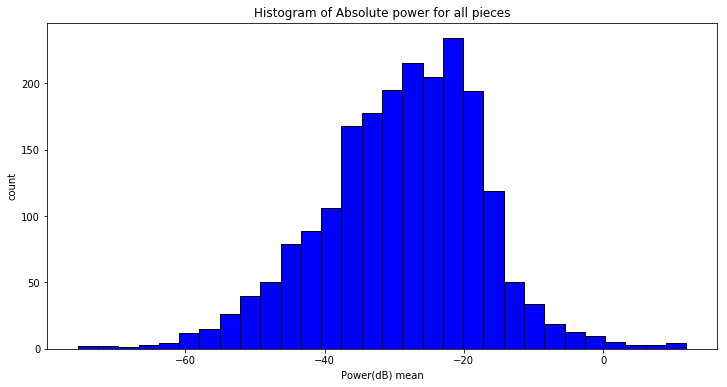

In [32]:
# histogram
plt.hist(df.dropna()['Absolute power(dB)mean'], color = 'blue', edgecolor = 'black', bins=30)
plt.title('Histogram of Absolute power for all pieces')
plt.xlabel('Power(dB) mean')
plt.ylabel('count')

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

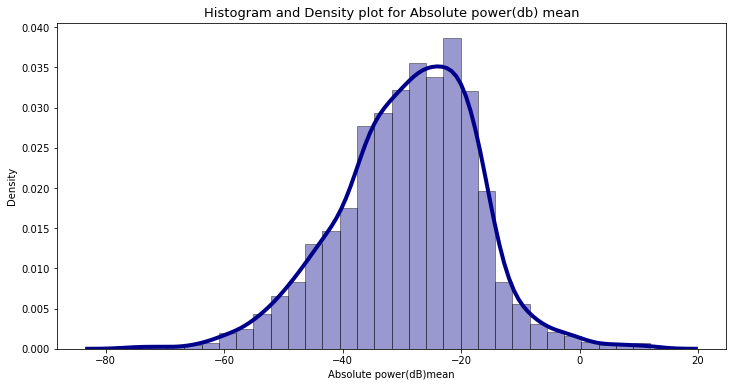

In [33]:
sns.distplot(df.dropna()['Absolute power(dB)mean'], hist=True, kde=True, 
             bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('Histogram and Density plot for Absolute power(db) mean', size = 13)
plt.ylabel('Density')

Text(0,0.5,'count')

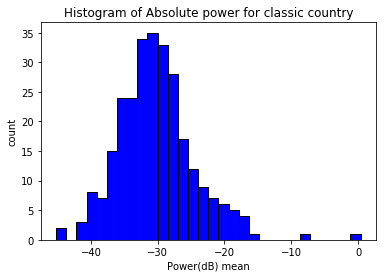

In [4]:
# matplotlib histogram
plt.hist(df_cc['Absolute power(dB)mean'], color = 'blue', edgecolor = 'black', bins=30)
# Add labels
plt.title('Histogram of Absolute power for classic country')
plt.xlabel('Power(dB) mean')
plt.ylabel('count')

Text(0,0.5,'count')

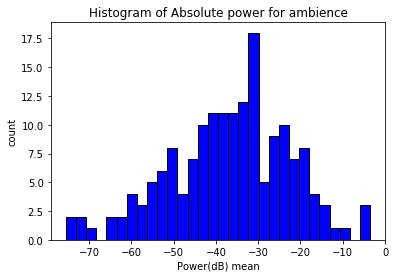

In [5]:
# matplotlib histogram
plt.hist(df_amb['Absolute power(dB)mean'], color = 'blue', edgecolor = 'black', bins=30)
# Add labels
plt.title('Histogram of Absolute power for ambience')
plt.xlabel('Power(dB) mean')
plt.ylabel('count')

Text(0.5,1,'Histogram of Absolute power')

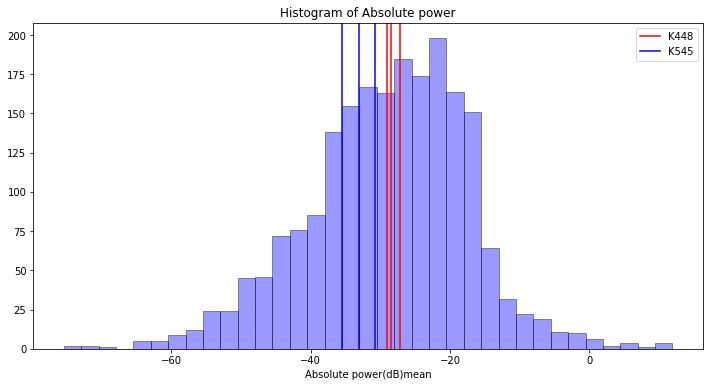

In [36]:
# seaborn histogram
sns.distplot(df.dropna()['Absolute power(dB)mean'], hist=True, kde=False, bins=35, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.axvline(x=-29.07, color='red', label='K448')
plt.axvline(x=-28.40, color='red')
plt.axvline(x=-27.22, color='red')
plt.axvline(x=-35.54, color='blue', label='K545')
plt.axvline(x=-33.12, color='blue')
plt.axvline(x=-30.79, color='blue')
plt.legend()
plt.title('Histogram of Absolute power')

# Zooming in

(-40, -20)

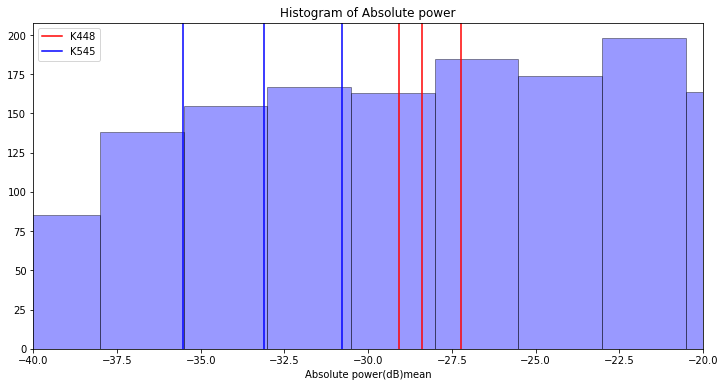

In [39]:
# seaborn histogram
sns.distplot(df.dropna()['Absolute power(dB)mean'], hist=True, kde=False, bins=35, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.axvline(x=-29.07, color='red', label='K448')
plt.axvline(x=-28.40, color='red')
plt.axvline(x=-27.22, color='red')
plt.axvline(x=-35.54, color='blue', label='K545')
plt.axvline(x=-33.12, color='blue')
plt.axvline(x=-30.79, color='blue')
plt.legend()
plt.title('Histogram of Absolute power')
plt.xlim(-40, -20)

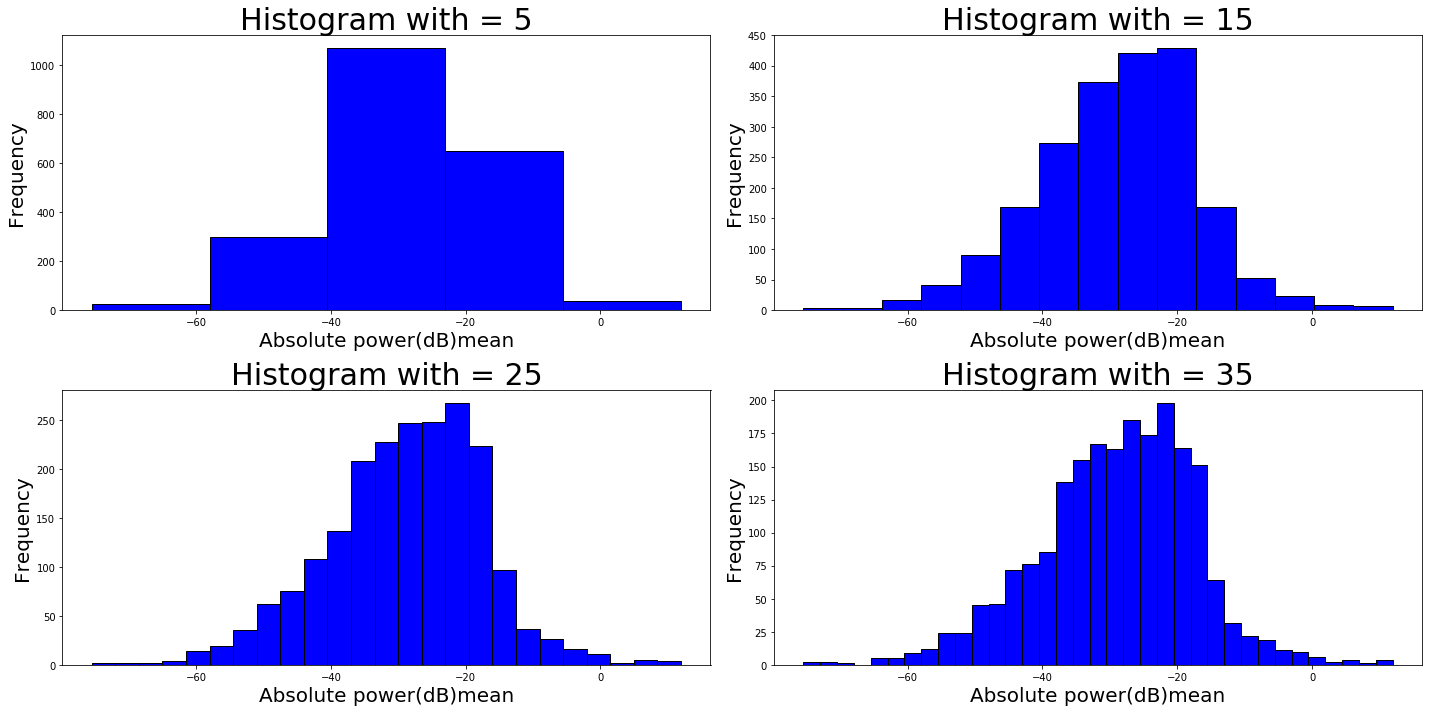

In [40]:
# Showing 4 different binwidths

plt.figure(figsize=(20,10))
for i, binwidth in enumerate([5, 15, 25, 35]):
    
    # Set up the plot
    #plt.figure(figsize=(5,10))
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(df.dropna()['Absolute power(dB)mean'], bins = binwidth,
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with = %d' % binwidth, size = 30)
    ax.set_xlabel('Absolute power(dB)mean', size = 20)
    ax.set_ylabel('Frequency', size= 20)

plt.tight_layout()
plt.show()

## Mean Mod Spec for different genres

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

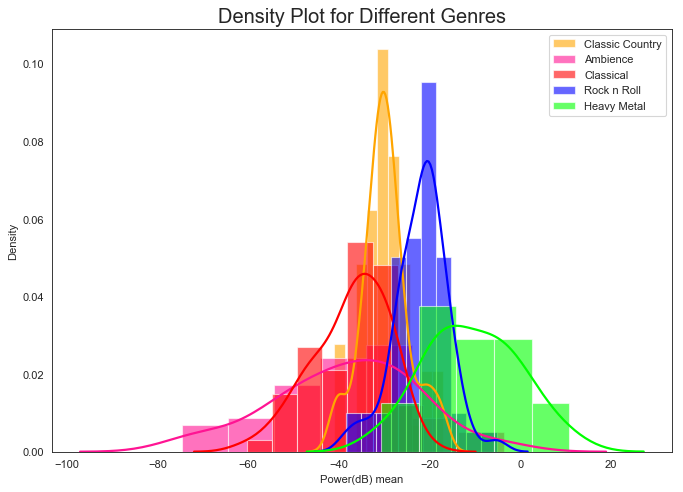

In [41]:
import seaborn as sns
sns.set_style("white")

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
#sns.distplot(x1, color="dodgerblue", label="Compact", **kwargs)
sns.distplot(sample_df_cc.dropna()['Absolute power(dB)mean'].dropna(), color="orange", label="Classic Country", **kwargs)
sns.distplot(sample_df_amb.dropna()['Absolute power(dB)mean'].dropna(), color="deeppink", label="Ambience", **kwargs)
#sns.distplot(sample_df_nw['Absolute power(dB)mean'].dropna(), color="b", label="Non Western", **kwargs)
sns.distplot(sample_df_class.dropna()['Absolute power(dB)mean'].dropna(), color="red", label="Classical", **kwargs)
sns.distplot(sample_df_rnr.dropna()['Absolute power(dB)mean'].dropna(), color="b", label="Rock n Roll", **kwargs)
sns.distplot(sample_df_hm.dropna()['Absolute power(dB)mean'].dropna(), color="lime", label="Heavy Metal", **kwargs)


plt.legend();
plt.title('Density Plot for Different Genres', size = 18)
plt.xlabel('Power(dB) mean')
plt.ylabel('Density')
